## Import Data

In [1]:
import numpy as np
from feature_engine.creation import CyclicalFeatures
from freqtrade.strategy import IStrategy, BooleanParameter, IntParameter
from functools import reduce
from freqtrade.litmus.label_helpers import tripple_barrier
from freqtrade.litmus import indicator_helpers as ih
from pandas import DataFrame
from technical import qtpylib

import logging
import pandas as pd
import pandas_ta as pta
import talib.abstract as ta

from fracdiff.sklearn import FracdiffStat

from freqtrade.data.history import load_pair_history
from freqtrade.enums import CandleType
from freqtrade.configuration import Configuration

import os
from pathlib import Path

from sklearn.model_selection import train_test_split

import logging
import numpy as np
import numpy.typing as npt
import pandas as pd
import tscv

from BorutaShap import BorutaShap
from feature_engine.selection import DropCorrelatedFeatures
from freqtrade.freqai.data_kitchen import FreqaiDataKitchen
from freqtrade.freqai.freqai_interface import IFreqaiModel
from freqtrade.litmus.model_helpers import (MergedModel,
                                            get_rfecv_feature_importance,
                                            threshold_from_desired_precision)
from freqtrade.litmus.db_helpers import save_df_to_db
from pandas import DataFrame
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from time import time
from typing import Any, Dict, Tuple
import sys

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

from feature_engine.timeseries.forecasting import LagFeatures

logger = logging.getLogger()
logger.addHandler(logging.StreamHandler(stream=sys.stdout))
logger.setLevel(logging.INFO)

In [2]:
# Change directory
# Modify this cell to insure that the output shows the correct path.
# Define all paths relative to the project root shown in the cell output

project_root = "litmus/freqtrade"
i=0
try:
    os.chdirdir(project_root)
    assert Path('LICENSE').is_file()
except:
    while i<4 and (not Path('LICENSE').is_file()):
        os.chdir(Path(Path.cwd(), '../'))
        i+=1
    project_root = Path.cwd()
print(Path.cwd())

/Users/markdregan/Dev/litmus


In [3]:
# Customize these according to your needs.

# Initialize empty configuration object
# config = Configuration.from_files([])
# Optionally (recommended), use existing configuration file

config = Configuration.from_files(["user_data/strategies/config.LitmusMLDP.json", 
                                   "user_data/strategies/config.exchange_secret.json"])

# Define some constants
config["timeframe"] = "3m"
# Name of the strategy class
config["strategy"] = "LitmusMLDPStrategy"
# Location of the data
data_location = config["datadir"]
# Pair to analyze - Only use one pair here
pair = "SOL/USDT:USDT"

Using config: user_data/strategies/config.LitmusMLDP.json ...
Using config: user_data/strategies/config.exchange_secret.json ...
Verbosity set to 0
`force_entry_enable` RPC message enabled.
Using user-data directory: /Users/markdregan/Dev/litmus/user_data ...
Using data directory: /Users/markdregan/Dev/litmus/user_data/data/binance ...
Checking exchange...
Exchange "binance" is officially supported by the Freqtrade development team.
Using pairlist from configuration.


In [4]:
# Load data using values set above

dataframe = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair=pair,
                            data_format = "json",  # Make sure to update this to your data
                            candle_type=CandleType.FUTURES,
                            )

# Confirm success
print(f"Loaded {len(dataframe)} rows of data for {pair} from {data_location}")

Loaded 70277 rows of data for SOL/USDT:USDT from /Users/markdregan/Dev/litmus/user_data/data/binance


## Config

In [5]:
freqai_config = {
        "enabled": True,
        "purge_old_models": True,
        "train_period_days": 100,
        "backtest_period_days": 1,
        "fit_live_predictions_candles": 0,
        "identifier": "LitmusMLDP",
        "fixed_leverage": 1,
        "feature_parameters": {
            "include_timeframes": [
                "3m",
                "30m"
            ],
            "include_corr_pairlist": [
                "BTC/USDT:USDT"
            ],
            "label_period_candles": 0,
            "include_shifted_candles": 4,
            "DI_threshold": 10,
            "weight_factor": 0.7,
            "principal_component_analysis": False,
            "plot_feature_importances": 0,
            "use_SVM_to_remove_outliers": False,
            "svm_params": {
                "shuffle": False,
                "nu": 0.05
            },
            "use_DBSCAN_to_remove_outliers": False,
            "inlier_metric_window": 40,
            "stratify_training_data": 0,
            "indicator_periods_candles": [30, 100],
            "noise_standard_deviation": 0.00,
            "reverse_train_test_order": False
        },
        "feature_selection": {
            "drop_weak_rfecv_rank": {
                "enabled": False,
                "exclude_rank_threshold": 2,
                "exclude_ratio_threshold": 0.7,
                "chance_excluded": 0.9,
                "keep_rank_threshold": 1,
                "keep_ratio_threshold": 0.9,
                "min_num_trials": 5
            },
            "greedy_selection": {
                "enabled": True,
                "threshold": 0.97
            },
            "drop_rows_meta_model": {
                "enabled": True
            },
            "boruta_selection": {
                "enabled": False,
                "importance_measure": "gini",
                "percentile": 80,
                "n_trials": 100,
                "drop_tentative": True,
                "sample": False,
                "train_or_test": "test",
                "normalize": True,
                "verbose": False
            },
            "rfecv": {
                "enabled": True,
                "cv_n_splits": 5,
                "cv_gap_before": 500,
                "cv_gap_after": 500,
                "min_features_to_select": 10,
                "step_pct": 0.05,
                "scoring": "neg_log_loss",
                "n_jobs": 6,
                "verbose": 1
            }
        },
        "data_split_parameters": {
            "test_size": 0.5,
            "shuffle": False
        },
        "trigger_parameters": {
            "fbeta_entry": 1,
            "fbeta_exit": 1,
            "smoothing_window": 20,
            "desired_precision": 0.5
        },
        "target_parameters": {
            "tmb_long_upper": 0.005,
            "tmb_long_lower": 0.005,
            "tmb_long_window": 10,
            "tmb_short_upper": 0.005,
            "tmb_short_lower": 0.005,
            "tmb_short_window": 10,
            "primary_perf_window": 40
        },
        "model_training_parameters": {
            "n_estimators": 1000,
            "criterion": "entropy",
            "class_weight": "balanced_subsample",
            "min_weight_fraction_leaf": 0.05
        },
        "extra_returns_per_train": {
            "total_time_&-primary_enter_long": 0,
            "total_time_&-primary_enter_short": 0,
            "num_trees_&-primary_enter_long": 0,
            "num_trees_&-primary_enter_short": 0,
            "fbeta_entry_thresh_&-primary_enter_long": 0,
            "fbeta_entry_thresh_&-primary_enter_short": 0,
            "max_fbeta_entry_&-primary_enter_long": 0,
            "max_fbeta_entry_&-primary_enter_short": 0,
            "desired_precision_threshold_&-primary_enter_long": 0,
            "desired_precision_threshold_&-primary_enter_short": 0,
            "resulting_recall_&-primary_enter_long": 0,
            "resulting_recall_&-primary_enter_short": 0,
            "best_cv_score_&-primary_enter_long": 0,
            "best_cv_score_&-primary_enter_short": 0
        }
    }

## Feature engineering

In [6]:
# feature_engineering_expand_all

for period in [8, 16, 32, 64, 128]:

    dataframe[f"%-rsi-{period}"] = ta.RSI(dataframe, timeperiod=period)
    dataframe[f"%-mfi-{period}"] = ta.MFI(dataframe, timeperiod=period)
    dataframe[f"%-adx-{period}"] = ta.ADX(dataframe, timeperiod=period)
    dataframe[f"%-sma-{period}"] = ta.SMA(dataframe, timeperiod=period)
    dataframe[f"%-ema-{period}"] = ta.EMA(dataframe, timeperiod=period)
    dataframe[f"%-cci-{period}"] = ta.CCI(dataframe, timeperiod=period)
    dataframe[f"%-er-{period}"] = pta.er(dataframe['close'], length=period)
    dataframe[f"%-rocr-{period}"] = ta.ROCR(dataframe, timeperiod=period)
    dataframe[f"%-cmf-{period}"] = ih.chaikin_mf(dataframe, periods=period)
    dataframe[f"%-tcp-{period}"] = ih.top_percent_change(dataframe, period)
    dataframe[f"%-cti-{period}"] = pta.cti(dataframe['close'], length=period)
    dataframe[f"%-chop-{period}"] = qtpylib.chopiness(dataframe, period)
    dataframe[f"%-linear-{period}"] = ta.LINEARREG_ANGLE(dataframe['close'], timeperiod=period)

    dataframe["%-obv"] = ta.OBV(dataframe)

    bollinger = qtpylib.bollinger_bands(
        qtpylib.typical_price(dataframe), window=period, stds=2.2
    )
    dataframe["bb_lowerband"] = bollinger["lower"]
    dataframe["bb_middleband"] = bollinger["mid"]
    dataframe["bb_upperband"] = bollinger["upper"]

    dataframe[f"%-bb_width-{period}"] = (
        dataframe["bb_upperband"]
        - dataframe["bb_lowerband"]
    ) / dataframe["bb_middleband"]
    dataframe[f"%-close-bb_lower-{period}"] = (
        dataframe["close"] / dataframe["bb_lowerband"]
    )

    dataframe[f"%-roc-{period}"] = ta.ROC(dataframe, timeperiod=period)

    dataframe[f"%-relative_volume-{period}"] = (
        dataframe["volume"] / dataframe["volume"].rolling(period).mean()
    )

    # Absolute Price Oscillator
    dataframe[f"%-apo-{period}"] = ta.APO(
        dataframe["close"], fastperiod=int(period / 2), slowperiod=period, matype=0)

    # PPO (Percentage Price Oscilator)
    dataframe[f"%-ppo-{period}"] = ta.PPO(
        dataframe["close"], fastperiod=int(period / 2), slowperiod=period, matype=0)

    # MACD (macd, macdsignal, macdhist)
    _, _, macdhist = ta.MACD(
        dataframe["close"], fastperiod=int(period / 2),
        slowperiod=period, signalperiod=int(3 * period / 4))
    dataframe[f"%-macdhist-{period}"] = macdhist

    # Average True Range
    dataframe[f"%-atr-{period}"] = ta.ATR(
        dataframe["high"], dataframe["low"], dataframe["close"], timeperiod=period)

In [7]:
# Add lagged features

temp_feature_cols = [c for c in dataframe.columns if c.startswith("%")]
num_lags_param = freqai_config["feature_parameters"]["include_shifted_candles"]
p = [1,2,3,4]

lag_feat = LagFeatures(variables=temp_feature_cols, periods=p, 
                       missing_values='ignore', drop_original=True)

dataframe_lagged = lag_feat.fit_transform(dataframe)

In [8]:
dataframe = dataframe_lagged

In [9]:
# feature_engineering_expand_basic

dataframe["%-pct-change"] = dataframe["close"].pct_change()
dataframe["%-raw_volume"] = dataframe["volume"]
dataframe["%-raw_price"] = dataframe["close"]

# feature_engineering_standard
# Time features
dataframe["%-day_of_week"] = dataframe["date"].dt.dayofweek
dataframe["%-hour_of_day"] = dataframe["date"].dt.hour
cyclical_transform = CyclicalFeatures(
    variables=["%-day_of_week", "%-hour_of_day"], max_values=None, drop_original=True
)
dataframe = cyclical_transform.fit_transform(dataframe)

# Target features
target_params = {
            "tmb_long_upper": 0.005,
            "tmb_long_lower": 0.005,
            "tmb_long_window": 10,
            "tmb_short_upper": 0.005,
            "tmb_short_lower": 0.005,
            "tmb_short_window": 10,
            "primary_perf_window": 40
        }

# Indicators for primary
bollinger = qtpylib.bollinger_bands(
    qtpylib.typical_price(dataframe), window=25, stds=1.9
)
dataframe["mm_bb_lowerband"] = bollinger["lower"]
dataframe["mm_bb_middleband"] = bollinger["mid"]
dataframe["mm_bb_upperband"] = bollinger["upper"]

In [10]:
# Primary: Enter Long
dataframe["primary_enter_long"] = np.where(
dataframe["close"] < dataframe["mm_bb_lowerband"], True, False)

# Long: TBM Labeling
logger.info("Starting TBM: Long")
window = target_params["tmb_long_window"]
params = {
"upper_pct": target_params["tmb_long_upper"],
"lower_pct": target_params["tmb_long_lower"]
}
dataframe["primary_enter_long_tbm"] = (
dataframe["close"]
.shift(-window)
.rolling(window + 1)
.apply(tripple_barrier, kwargs=params)
)

# Long: Primary model performance a feature for meta model
dataframe["masked_shift_long_tbm"] = np.where(
dataframe["primary_enter_long"].shift(window),
dataframe["primary_enter_long_tbm"].shift(window),
np.nan)
dataframe["%-primary_long_perf_mean"] = dataframe["masked_shift_long_tbm"].rolling(
window=target_params["primary_perf_window"],
min_periods=0).apply(lambda x: x[~np.isnan(x)].mean()).fillna(0)
dataframe["%-primary_long_perf_std"] = dataframe["masked_shift_long_tbm"].rolling(
window=target_params["primary_perf_window"],
min_periods=0).apply(lambda x: x[~np.isnan(x)].std()).fillna(0)
dataframe["%-primary_long_perf_count"] = dataframe["masked_shift_long_tbm"].rolling(
window=target_params["primary_perf_window"],
min_periods=0).apply(lambda x: x[~np.isnan(x)].count()).fillna(0)


# Primary: Enter Short
dataframe["primary_enter_short"] = np.where(
dataframe["close"] > dataframe["mm_bb_upperband"], True, False)

# Short: TBM Labeling
logger.info("Starting TBM: Short")
window = target_params["tmb_short_window"]
params = {
"upper_pct": target_params["tmb_short_upper"],
"lower_pct": target_params["tmb_short_lower"]
}
dataframe["primary_enter_short_tbm"] = (
dataframe["close"]
.shift(-window)
.rolling(window + 1)
.apply(tripple_barrier, kwargs=params)
)

# Short: Primary model performance a feature for meta model
dataframe["masked_shift_short_tbm"] = np.where(
dataframe["primary_enter_short"].shift(window),
dataframe["primary_enter_short_tbm"].shift(window),
np.nan)
dataframe["%-primary_short_perf_mean"] = dataframe["masked_shift_short_tbm"].rolling(
window=target_params["primary_perf_window"],
min_periods=0).apply(lambda x: x[~np.isnan(x)].mean()).fillna(0)
dataframe["%-primary_short_perf_std"] = dataframe["masked_shift_short_tbm"].rolling(
window=target_params["primary_perf_window"],
min_periods=0).apply(lambda x: x[~np.isnan(x)].std()).fillna(0)
dataframe["%-primary_short_perf_count"] = dataframe["masked_shift_short_tbm"].rolling(
window=target_params["primary_perf_window"],
min_periods=0).apply(lambda x: x[~np.isnan(x)].count()).fillna(0)

# set_freqai_targets
# Long Entry
tbm_map = {1: "a_win_long", 0: "loss_long", -1: "loss_long"}
dataframe["&-primary_enter_long"] = dataframe["primary_enter_long_tbm"].map(tbm_map)
dataframe["&-primary_enter_long"] = np.where(
    dataframe["primary_enter_long"], dataframe["&-primary_enter_long"], "drop-row")
logger.info("Label counts for primary long: ")
print(dataframe.groupby("&-primary_enter_long").size())

# Short Entry
tbm_map = {1: "loss_short", 0: "loss_short", -1: "a_win_short"}
dataframe["&-primary_enter_short"] = dataframe["primary_enter_short_tbm"].map(tbm_map)
dataframe["&-primary_enter_short"] = np.where(
    dataframe["primary_enter_short"], dataframe["&-primary_enter_short"], "drop-row")
logger.info("Label counts for primary short: ")
print(dataframe.groupby("&-primary_enter_short").size())

# Just for XGBoost
le = LabelEncoder()
dataframe["&-primary_enter_long"] = pd.Series(le.fit_transform(dataframe["&-primary_enter_long"]), dtype="int64")

le = LabelEncoder()
dataframe["&-primary_enter_short"] = pd.Series(le.fit_transform(dataframe["&-primary_enter_short"]), dtype="int64")

Starting TBM: Long
Starting TBM: Short
Label counts for primary long: 
&-primary_enter_long
a_win_long     1745
drop-row      64247
loss_long      4283
dtype: int64
Label counts for primary short: 
&-primary_enter_short
a_win_short     1599
drop-row       64640
loss_short      4038
dtype: int64


## Filtering & splitting

In [22]:
feature_cols = [c for c in dataframe.columns if c.startswith("%")]
target_cols = [c for c in dataframe.columns if c.startswith("&")]

model_df = dataframe[feature_cols + target_cols].dropna()

X = model_df[feature_cols]
y = model_df[target_cols]

# Filter down to one target
y = y["&-primary_enter_long"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, shuffle=False)

eval_set = [(X_test, y_test)]

## Model

In [26]:
temp_estimator = xgb.XGBClassifier(n_estimators=1000, verbosity=1)

temp_estimator.fit(X_train, y_train, eval_metric="mlogloss", eval_set=eval_set,
                  early_stopping_rounds=20)

[0]	validation_0-mlogloss:0.74617
[1]	validation_0-mlogloss:0.54509
[2]	validation_0-mlogloss:0.42161
[3]	validation_0-mlogloss:0.33430
[4]	validation_0-mlogloss:0.27236
[5]	validation_0-mlogloss:0.22891
[6]	validation_0-mlogloss:0.19792
[7]	validation_0-mlogloss:0.17548
[8]	validation_0-mlogloss:0.15861
[9]	validation_0-mlogloss:0.14599
[10]	validation_0-mlogloss:0.13732
[11]	validation_0-mlogloss:0.13076
[12]	validation_0-mlogloss:0.12629
[13]	validation_0-mlogloss:0.12194
[14]	validation_0-mlogloss:0.11882
[15]	validation_0-mlogloss:0.11655
[16]	validation_0-mlogloss:0.11476
[17]	validation_0-mlogloss:0.11328
[18]	validation_0-mlogloss:0.11221
[19]	validation_0-mlogloss:0.11134
[20]	validation_0-mlogloss:0.11095
[21]	validation_0-mlogloss:0.11074
[22]	validation_0-mlogloss:0.11039
[23]	validation_0-mlogloss:0.11006
[24]	validation_0-mlogloss:0.11008
[25]	validation_0-mlogloss:0.10972
[26]	validation_0-mlogloss:0.10960
[27]	validation_0-mlogloss:0.10942
[28]	validation_0-mlogloss:0.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [12]:
start_time = time()

model_list = []
model_features_list = []
model_type_list = []


logger.info(f"Start training")

# Drop low performing features based on RFECV rank results
if freqai_config["feature_selection"]["drop_weak_rfecv_rank"].get(
        "enabled", False):

    rfecv_params = freqai_config["feature_selection"]["drop_weak_rfecv_rank"]

    feat_df = get_rfecv_feature_importance(
        model=t, pair=dk.pair,
        exclude_rank_threshold=rfecv_params["exclude_rank_threshold"],
        keep_rank_threshold=rfecv_params["keep_rank_threshold"],
        exclude_ratio_threshold=rfecv_params["exclude_ratio_threshold"],
        keep_ratio_threshold=rfecv_params["keep_ratio_threshold"],
        chance_excluded=rfecv_params["chance_excluded"],
        min_num_trials=rfecv_params["min_num_trials"])

    cols_to_drop = feat_df[feat_df["confirm_exclude"]]["feature_id"].to_numpy()
    cols_to_keep = feat_df[feat_df["confirm_keep"]]["feature_id"].to_numpy()

    X_train = X_train.drop(columns=cols_to_drop, errors="ignore")
    X_test = X_test.drop(columns=cols_to_drop, errors="ignore")

    logger.info(f"RFECV: Dropping {len(cols_to_drop)} and "
                f"keeping {len(cols_to_keep)} features based on prior train cycles.")

# Drop features using Greedy Correlated Selection
if freqai_config["feature_selection"]["greedy_selection"].get("enabled", False):
    num_feat = len(X_train.columns)
    logger.info(f"Starting Greedy Feature Selection for {num_feat} features")

    # Get config params
    greedy_selection_params = freqai_config["feature_selection"]["greedy_selection"]

    # cols_to_analyze = [c for c in X_train.columns if c not in cols_to_keep]
    # cols_to_analyze = X_train.columns

    greedy_selection = DropCorrelatedFeatures(
        method="pearson",
        threshold=greedy_selection_params["threshold"], missing_values="ignore",
        confirm_variables=False)

    X_train = greedy_selection.fit_transform(X_train, y_train)
    X_test = greedy_selection.transform(X_test)

    num_remaining = len(X_train.columns)
    num_dropped = len(greedy_selection.features_to_drop_)
    # dk.data["extra_returns_per_train"][f"num_dropped_greedy_{t}"] = num_dropped
    logger.info(f"Dropping {num_dropped} correlated features using greedy. "
                f"{num_remaining} remaining.")

# Drop rows for meta-model to align with primary entries only
if freqai_config["feature_selection"]["drop_rows_meta_model"].get("enabled", False):
    # Boolean mask for rows to keep (True)
    train_row_keep = np.where(y_train == "drop-row", False, True)
    test_row_keep = np.where(y_test == "drop-row", False, True)

    # Drop rows
    X_train = X_train[train_row_keep]
    y_train = y_train[train_row_keep]
    X_test = X_test[test_row_keep]
    y_test = y_test[test_row_keep]

    logger.info(f"Meta-model prep: Dropped {len(train_row_keep)} rows from train data. "
                f"{len(y_train)} remaining.")
    logger.info(f"Meta-model prep: Dropped {len(test_row_keep)} rows from test data. "
                f"{len(y_test)} remaining.")

# Boruta Feature Selection
if freqai_config["feature_selection"]["boruta_selection"].get("enabled", False):
    logger.info(f"Starting boruta for {len(X_train.columns)} features")
    boruta_params = freqai_config["feature_selection"]["boruta_selection"]

    boruta_selector = BorutaShap(
        importance_measure=boruta_params["importance_measure"],
        percentile=boruta_params["percentile"],
        classification=True)
    boruta_selector.fit(
        X=X_train, y=y_train, n_trials=boruta_params["n_trials"],
        sample=boruta_params["sample"],
        train_or_test=boruta_params["train_or_test"],
        normalize=boruta_params["normalize"], verbose=boruta_params["verbose"])

    # Incase there are undecided features
    if boruta_params.get("drop_tentative", False):
        boruta_selector.TentativeRoughFix()

    X_train = boruta_selector.Subset()
    X_test = X_test.loc[:, X_train.columns]

    logger.info(f"Boruta selected {len(X_train.columns)} features")

# RFECV: Recursive Feature Elimination with Cross Validation
if freqai_config["feature_selection"]["rfecv"].get("enabled", False):
    num_feat = len(X_train.columns)
    logger.info(f"Starting RFECV process for {num_feat} features")

    # Get config params
    rfecv_params = freqai_config["feature_selection"]["rfecv"]
    model_params = freqai_config["model_training_parameters"]

    """rfe_estimator = RandomForestClassifier(
        **model_params
    )"""
    
    rfe_estimator = xgb.XGBClassifier(n_estimators=1000, verbose=1)

    cv = tscv.GapKFold(
        n_splits=rfecv_params["cv_n_splits"],
        gap_before=rfecv_params["cv_gap_before"],
        gap_after=rfecv_params["cv_gap_after"])

    rfecv = RFECV(
        estimator=rfe_estimator,
        step=rfecv_params["step_pct"],
        cv=cv,
        scoring=rfecv_params["scoring"],
        verbose=rfecv_params["verbose"],
        min_features_to_select=rfecv_params["min_features_to_select"],
        n_jobs=rfecv_params["n_jobs"],
    )

    rfecv.fit(X_train, y_train)
    original_col_names = X_train.columns
    rfecv_col_names = rfecv.get_feature_names_out()
    X_train = pd.DataFrame(rfecv.transform(X_train), columns=rfecv_col_names)
    X_test = pd.DataFrame(rfecv.transform(X_test), columns=rfecv_col_names)

    num_remaining = len(X_train.columns)
    num_dropped = num_feat - num_remaining
    logger.info(f"Dropping {num_dropped} features using RFECV. "
                f"{num_remaining} remaining.")

    # Store feature ranks to database
    feat_rank = rfecv.ranking_
    feat_id = original_col_names
    best_cv_score = rfecv.cv_results_["mean_test_score"].max()
    feat_rank_df = pd.DataFrame(
        np.column_stack([feat_id, feat_rank]), columns=["feature_id", "feature_rank"])
    feat_rank_df["train_time"] = time()
    feat_rank_df["pair"] = "SOL"
    feat_rank_df["model"] = "&-primary_enter_long"
    feat_rank_df["best_cv_score"] = best_cv_score
    feat_rank_df.set_index(
        keys=["model", "train_time", "pair", "feature_id"], inplace=True)
    save_df_to_db(df=feat_rank_df, table_name="feature_rfecv_rank")

    # Save metrics for plotting
    # dk.data["extra_returns_per_train"][f"best_cv_score_{t}"] = best_cv_score

# Train final model with reduced features
logger.info("Starting to train final model")
model_params = freqai_config["model_training_parameters"]
rfecv_params = freqai_config["feature_selection"]["rfecv"]

cv = tscv.GapKFold(
    n_splits=rfecv_params["cv_n_splits"],
    gap_before=rfecv_params["cv_gap_before"],
    gap_after=rfecv_params["cv_gap_after"])

"""grid = {"max_depth": [3, 6, None],
        "min_samples_split": sp_randint(2, 11),
        "min_samples_leaf": sp_randint(1, 11),
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"],
        "min_weight_fraction_leaf": [0, 0.01, 0.05],
        "class_weight": ["balanced_subsample", "balanced"]
        }"""

xgb_grid = {'max_depth': [3, 6, None],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
        }

estimator = RandomForestClassifier(**model_params)
model = RandomizedSearchCV(estimator, param_distributions=xgb_grid, scoring="neg_log_loss", n_jobs=-1, cv=cv, verbose=10)

model.fit(X=X_train, y=y_train)

# Best params
print(f"Best params: {model.best_params_}")

# Prepare model details for MergedModel class
model_list.append(model)
model_type_list.append("sklearn")
model_features_list.append(X_train.columns.to_list())

end_time = time()
total_time = end_time - start_time
# dk.data["extra_returns_per_train"][f"total_time_{t}"] = total_time

# Model performance metrics
# y_pred_proba = model.predict_proba(X_test)[:, 0]
# logger.info(f"Model performance metrics for {t} and {dk.pair}")

"""
# Precision and recall stats
precision, recall, thresholds = precision_recall_curve(
    y_test, y_pred_proba, pos_label=model.classes_[0])

# Print summary of precision and recall table
pr_summary = np.column_stack([precision, recall, np.append(thresholds, [1])])
pr_summary_df = pd.DataFrame(pr_summary, columns=["precision", "recall", "thresholds"])
bins = np.linspace(start=0, stop=1, num=11)
pr_agg_df = pr_summary_df.groupby(pd.cut(pr_summary_df["thresholds"], bins=bins)).mean()
print(pr_agg_df)

# Get threshold for desired precision
desired_precision = freqai_config["trigger_parameters"].get("desired_precision", 1)
resulting_recall, desired_precision_threshold = threshold_from_desired_precision(
    precision, recall, thresholds, desired_precision=desired_precision)

# dk.data["extra_returns_per_train"][
    f"resulting_recall_{t}"] = resulting_recall
# dk.data["extra_returns_per_train"][
    f"desired_precision_threshold_{t}"] = desired_precision_threshold

logger.info(f"{t} - Resulting recall from desired precision: {resulting_recall}")
logger.info(f"{t} - Desired precision threshold: {desired_precision_threshold}")
"""


Start training
Starting Greedy Feature Selection for 437 features
Dropping 205 correlated features using greedy. 232 remaining.
Meta-model prep: Dropped 21005 rows from train data. 21005 remaining.
Meta-model prep: Dropped 49013 rows from test data. 49013 remaining.
Starting RFECV process for 232 features


KeyboardInterrupt: 

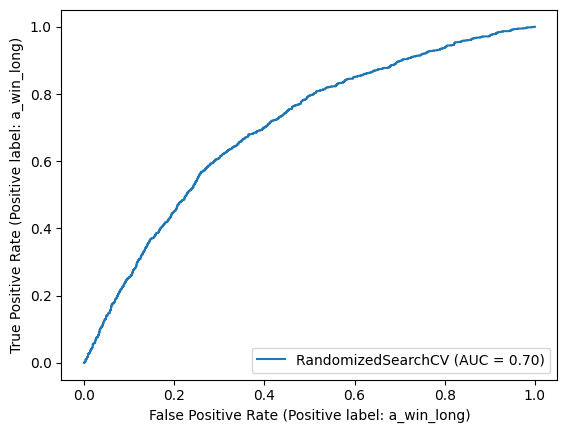

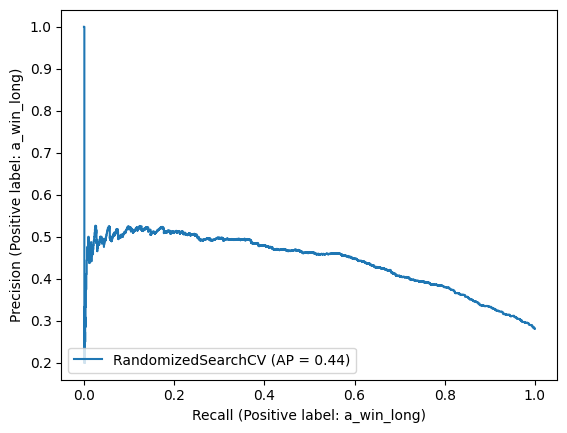

[CV 2/5; 2/10] START bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=6, min_samples_leaf=6, min_samples_split=5, min_weight_fraction_leaf=0.05
[CV 2/5; 2/10] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=6, min_samples_leaf=6, min_samples_split=5, min_weight_fraction_leaf=0.05;, score=-0.591 total time=   2.3s
[CV 2/5; 3/10] START bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=9, min_samples_split=7, min_weight_fraction_leaf=0
[CV 2/5; 3/10] END bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=9, min_samples_split=7, min_weight_fraction_leaf=0;, score=-0.574 total time=   3.4s
[CV 1/5; 5/10] START bootstrap=True, class_weight=balanced, criterion=gini, max_depth=None, min_samples_leaf=8, min_samples_split=5, min_weight_fraction_leaf=0
[CV 1/5; 5/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=None, min_samples_leaf=8, 

[CV 3/5; 2/10] START bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=6, min_samples_leaf=6, min_samples_split=5, min_weight_fraction_leaf=0.05
[CV 3/5; 2/10] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=6, min_samples_leaf=6, min_samples_split=5, min_weight_fraction_leaf=0.05;, score=-0.646 total time=   2.0s
[CV 1/5; 3/10] START bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=9, min_samples_split=7, min_weight_fraction_leaf=0
[CV 1/5; 3/10] END bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=9, min_samples_split=7, min_weight_fraction_leaf=0;, score=-0.495 total time=   6.3s
[CV 2/5; 6/10] START bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0
[CV 2/5; 6/10] END bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_depth=6, 

In [14]:
roc_plot = RocCurveDisplay.from_estimator(model, X_test, y_test, pos_label="a_win_long")
pr_plot = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, pos_label="a_win_long")

In [36]:
pd.DataFrame(model.predict_proba(X_test), columns=model.classes_)

,a_win_long,loss_long
0,0.215461,0.784539
1,0.224933,0.775067
2,0.240046,0.759954
3,0.246495,0.753505
4,0.277898,0.722102
...,...,...
4090,0.390417,0.609583
4091,0.418808,0.581192
4092,0.465050,0.534950
4093,0.572171,0.427829
